In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# from sklearn import ?
# from sklearn.metrics import ?

<br>

## 1. Preparing dataset (2번부터 실습 진행)

In [11]:
x_data = pd.read_csv('titanic.csv')
x_data.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


## Data info

- **PassengerId** : Unique ID of passenger
- **Survived** : 0 = No, 1 = Yes
- **pclass** : Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd)
- **sibsp** : # of siblings & spouses aboard the Titanic
- **parch** : # of parents / children aboard the Titanic
- **ticket** : Ticket number
- **cabin** : Cabin number
- **embarked** : Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

In [12]:
y_data = data_df[['Survived']]
# y_data.head(3)

<br>

## 2. Feature engineering & Feature selection

#### 시도해볼 수 있는 전략들

- 불필요한 열이나 예측에 방해가 되는 열은 아예 지우기 (ex. PassengerId)
- 결측치 채우기 
- Text로 되어있는 Category(Factor)는 숫자로 바꿔주기 (ex. Male/Female -> 0/1)
- 실수 범위를 구간 범위로 바꿔주기 
- 필요한 경우 기존 열을 바탕으로 새로운 열을 계산해 추가하기

In [13]:
# # 기본적인 결측치 채우는 방법
# mean_age = x_data['Age'].median(skipna=True)
# x_data['Age'] = x_data['Age'].fillna(mean_age) # or .fillna(int/float/str 값)

In [14]:
#필요한 컬럼들만 추려내기
columns = ['Pclass','Name','Sex','Age','SibSp','Parch','Fare','Embarked']

In [15]:
x_data = x_data[columns]

In [16]:
# 범주형 데이터 숫자로 변환
x_data['Embarked'] = x_data['Embarked'].map(lambda x: 1 if x == 'S' else (2 if x == 'C' else 3))
x_data['Embarked'] = x_data['Embarked'].fillna(x_data['Embarked'].mode()) # 최빈값 대체

x_data['Last Name'] = data_df['Name'].map(lambda x : x.split(',')[0])
# Mr , Ms , Master.. 구분
x_data['Title'] = data_df['Name'].map(lambda x : x.split(',')[1].split('.')[0].replace(' ',''))
#성별 숫자로 변환
x_data['Sex'] = x_data['Sex'].map(lambda x : 1 if x == "male" else 0 )

In [17]:
x_data = x_data.drop(['Name'],axis=1)

In [18]:
#age 결측치 채우기 Title 별 평균값
missing_title = list(x_data['Title'][x_data['Age'].isnull()].unique())
for title in missing_title:
    age_filter = x_data[x_data['Age'].notnull()][x_data['Title']==title]
    get_mean=age_filter['Age'].mean()
    #print(title,get_mean )
    x_data['Age'][x_data['Title']==title]= x_data['Age'][x_data['Title']==title].fillna(get_mean)

x_data['Age']= x_data['Age'].astype(int)
x_data

for title in missing_title:
    age_filter = x_data[x_data['Age'].notnull()][x_data['Title']==title]
    get_mean=age_filter['Age'].mean()
    #print(title,get_mean )
    x_data['Age'][x_data['Title']==title]= x_data['Age'][x_data['Title']==title].fillna(get_mean)

x_data['Age']= x_data['Age'].astype(int)

In [19]:
x_data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Last Name,Title
0,3,1,22,1,0,7.2500,1,Braund,Mr
1,1,0,38,1,0,71.2833,2,Cumings,Mrs
2,3,0,26,0,0,7.9250,1,Heikkinen,Miss
3,1,0,35,1,0,53.1000,1,Futrelle,Mrs
4,3,1,35,0,0,8.0500,1,Allen,Mr


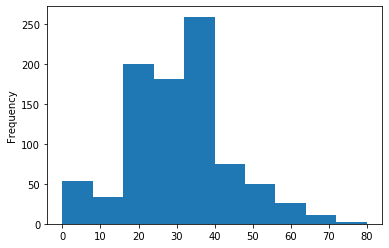

In [20]:
x_data['Age'].plot.hist()

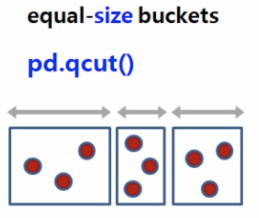

In [21]:
#갯수별로 구간 나누기
x_data['Fare_qcut'] = pd.qcut(x_data.Fare, q=5, labels=[0, 1, 2, 3, 4])
x_data['Age_qcut'] = pd.qcut(x_data.Age, q=5, labels=[0, 1, 2, 3, 4])

#모델 fit할때 Value error 방지
x_data['Fare_qcut'] = pd.to_numeric(x_data['Fare_qcut'])
x_data['Age_qcut'] = pd.to_numeric(x_data['Age_qcut'])

#Embarked one-hot-encoding
one_hot_Embarked = pd.get_dummies(x_data["Embarked"])
one_hot_Embarked.columns = ['Embarked1','Embarked2','Embarked3']
x_data = pd.concat([x_data,one_hot_Embarked],axis=1)

#Pclass one-hot-encoding
one_hot_Pclass = pd.get_dummies(x_data['Pclass'])
one_hot_Pclass.columns = ['Pclass1','Pcalss2','Pcalss3']
x_data = pd.concat([x_data,one_hot_Pclass], axis=1)

x_data

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Last Name,Title,Fare_qcut,Age_qcut,Embarked1,Embarked2,Embarked3,Pclass1,Pcalss2,Pcalss3
0,3,1,22,1,0,7.2500,1,Braund,Mr,0,1,1,0,0,0,0,1
1,1,0,38,1,0,71.2833,2,Cumings,Mrs,4,3,0,1,0,1,0,0
2,3,0,26,0,0,7.9250,1,Heikkinen,Miss,1,1,1,0,0,0,0,1
3,1,0,35,1,0,53.1000,1,Futrelle,Mrs,4,3,1,0,0,1,0,0
4,3,1,35,0,0,8.0500,1,Allen,Mr,1,3,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,2,1,27,0,0,13.0000,1,Montvila,Rev,2,2,1,0,0,0,1,0
887,1,0,19,0,0,30.0000,1,Graham,Miss,3,0,1,0,0,1,0,0
888,3,0,21,1,2,23.4500,1,Johnston,Miss,3,1,1,0,0,0,0,1
889,1,1,26,0,0,30.0000,2,Behr,Mr,3,1,0,1,0,1,0,0


In [22]:
#x_data["Family"] = x_data[["Parch", 'SibSp']].apply(lambda x: x.sum(), axis = 1  )

In [23]:
#사용하지 않는 열 제거
row_data = x_data.drop(['Title','Last Name','Age','Fare','Embarked','Pclass'] , axis=1)
#row_data = row_data.drop(['SibSp','Parch'],axis =1)
row_data.head()

,Sex,SibSp,Parch,Fare_qcut,Age_qcut,Embarked1,Embarked2,Embarked3,Pclass1,Pcalss2,Pcalss3
0,1,1,0,0,1,1,0,0,0,0,1
1,0,1,0,4,3,0,1,0,1,0,0
2,0,0,0,1,1,1,0,0,0,0,1
3,0,1,0,4,3,1,0,0,1,0,0
4,1,0,0,1,3,1,0,0,0,0,1


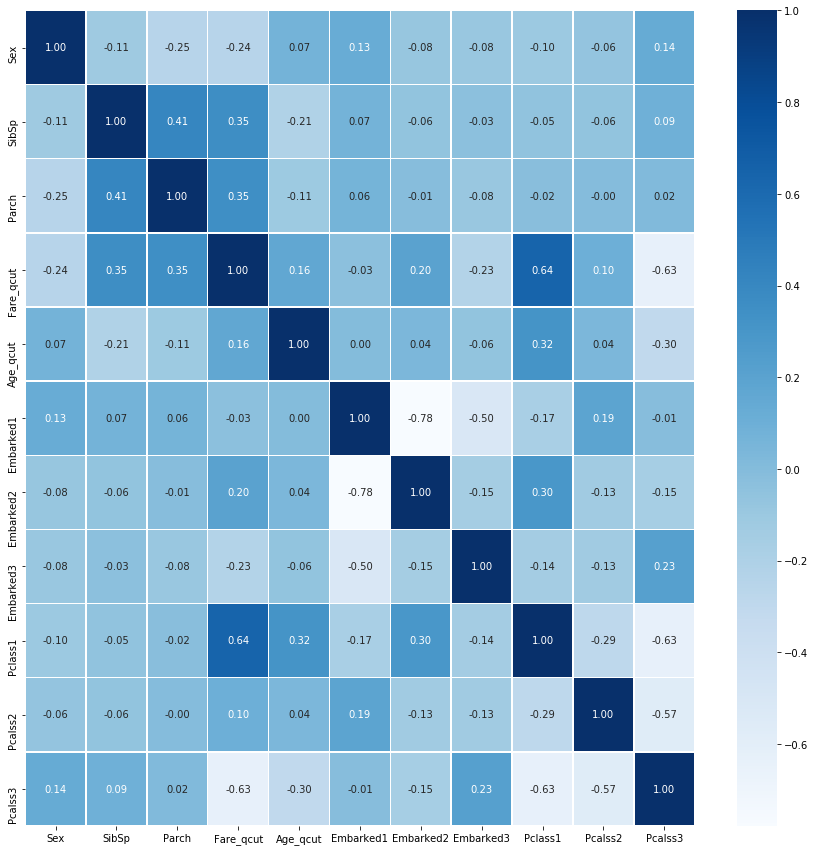

In [24]:
#corr 시각화
import seaborn as sns
plt.figure(figsize=(15,15))
sns.heatmap(data = row_data.corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')

<br>

## 2. Train - Test split (비율을 7:3 으로 유지해주시고, seed는 0을 적용해주세요)

In [25]:
from sklearn.model_selection import train_test_split
trainX ,testX , trainY , testY = train_test_split(row_data,y_data,test_size=0.3, random_state = 0)
print(trainX.shape,testX.shape,trainY.shape,testY.shape)

(623, 11) (268, 11) (623, 1) (268, 1)


<br>

## 3. Create model instance variable (동시에 여러 모델을 다른 이름으로 만들 수 있습니다.)

In [26]:
from sklearn import metrics
# 모델 함수 만들기
def train_and_test(model): 
    model.fit(trainX, trainY) 
    prediction = model.predict(testX)
    accuracy = round(metrics.accuracy_score(testY, prediction) * 100, 2) 
    print("Accuracy : ", accuracy, "%") 
    
    from sklearn.metrics import f1_score
    print(f"F1 Score: {round(f1_score(testY, prediction, average='micro') * 100, 2)}%")
    
    return prediction

In [27]:
#LinearSVC
from sklearn.svm import LinearSVC
clf_pred = train_and_test(LinearSVC())

Accuracy :  80.6 %
F1 Score: 80.6%


In [28]:
#Logistic
from sklearn.linear_model import LogisticRegression
log_pred = train_and_test(LogisticRegression()) 

Accuracy :  80.97 %
F1 Score: 80.97%


In [29]:
#LightGBM
from lightgbm import LGBMClassifier
lgb = LGBMClassifier(tree_method='gpu_hist')
lgb_predict = train_and_test(lgb)

[LightGBM] [Warning] Unknown parameter: tree_method
Accuracy :  83.21 %
F1 Score: 83.21%


In [30]:
#RandomForest
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=100, random_state=0)
forest_predict = train_and_test(forest)

Accuracy :  83.21 %
F1 Score: 83.21%


In [31]:
#XGBoost
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb_predict = train_and_test(xgb)

Accuracy :  83.58 %
F1 Score: 83.58%


<br>

## 4. K-Fold Cross Validation

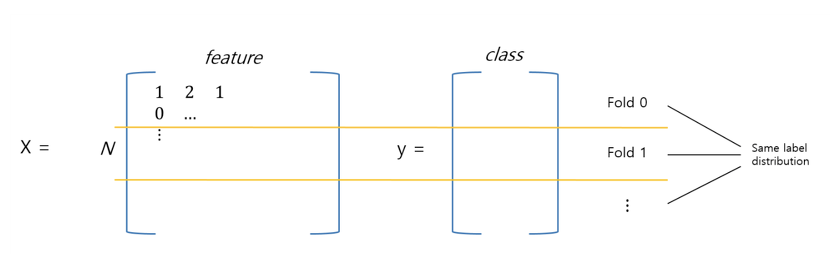

stratified 는 label 의 분포를 유지시켜준다고 생각하면 된다. 즉, 각 fold 안의 데이터셋의 label 분포가 전체 데이터셋의 label 분포를 따른다.

각 fold가 전체 데이터셋을 잘 대표한다.

In [119]:
from sklearn.model_selection import StratifiedKFold
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

In [132]:
from sklearn.model_selection import cross_val_score

logit_kfold = cross_val_score(LogisticRegression(),trainX,trainY , cv=skf)
linearSVC_kfold = cross_val_score(LinearSVC(),trainX,trainY , cv=skf)
xgb_kfold = cross_val_score(xgb,trainX,trainY , cv=skf)
forest_kfold = cross_val_score(forest,trainX,trainY , cv=skf)
lgb_kfold = cross_val_score(lgb,trainX,trainY , cv=skf)


print()

print(f"LogisticRegression : {logit_kfold[-1]}")
print(f"LinearSVC : {linearSVC_kfold[-1]}")
print(f"XGBoost : {xgb_kfold[-1]}")
print(f"Random forest : {forest_kfold[-1]}")
print(f"LightGBM : {lgb_kfold[-1]}")



[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] Unknown parameter: tree_method

LogisticRegression : 0.8064516129032258
LinearSVC : 0.7903225806451613
XGBoost : 0.8548387096774194
Random forest : 0.7983870967741935
LightGBM : 0.8306451612903226


In [135]:
from sklearn.metrics import confusion_matrix, classification_report

xgb_ = xgb.fit(trainX,trainY)

# XGBoost 모델
print(confusion_matrix(xgb_.predict(testX), testY))
print(classification_report(xgb_.predict(testX), testY))

[[156  32]
 [ 12  68]]
              precision    recall  f1-score   support

           0       0.93      0.83      0.88       188
           1       0.68      0.85      0.76        80

    accuracy                           0.84       268
   macro avg       0.80      0.84      0.82       268
weighted avg       0.85      0.84      0.84       268



In [136]:
# 라이브러리 임포트
from sklearn.metrics import roc_curve, auc

# GBM 커브 그리기 
model = xgb_
pred_test = model.predict_proba(testX)
# X축, Y축 생성
fpr, tpr, _ = roc_curve(y_true=testY, y_score=pred_test[:,1]) # real y & predicted y (based on "Sepal width")
roc_auc = auc(fpr, tpr) # AUC 면적의 값 (수치)

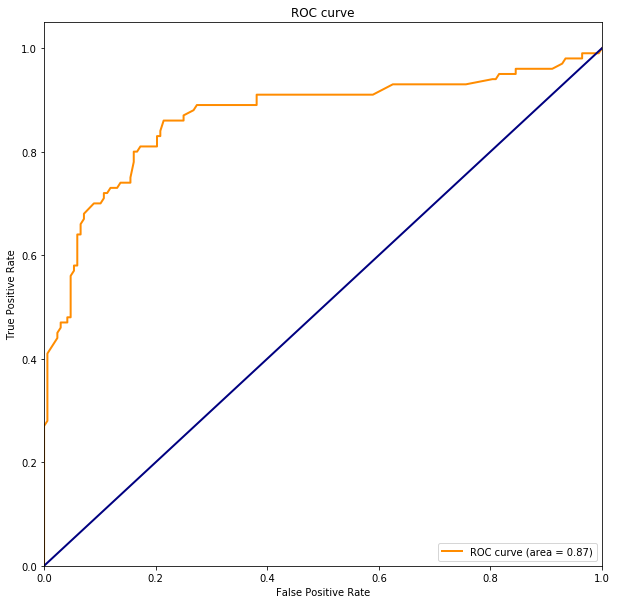

In [137]:
# GBM 커브 그래프 그리기
plt.figure(figsize=(10, 10))

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2)
# linestyle='—'
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title("ROC curve")

plt.show()